# SETOSim data processing

The goal here is to show how differently the process of evacuation occurs in the typhoon situation. In particular, the hope is to explore the time cost with different situations.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from os.path import isfile, join
import pylab as plt
from glob import glob
import subprocess
import re

import geopandas
from matplotlib_scalebar.scalebar import ScaleBar

from shapely import wkt

import seaborn as sns

## Reading and Cleaning the Data

Let's create some functions to help read in the basic data. 

In [426]:
waterFloodedFile = "/Users/swise/Projects/hitomi/data/RitsurinDemo/TakamatsuWaterFlooded.shp"
waterTyphoon16File = "/Users/swise/Projects/hitomi/data/elderDemo/typhoon16ForFinalViz.shp"
roadsFile = "/Users/swise/Projects/hitomi/data/roadsProj.shp"
baseShapefileFilename = "/Users/swise/Projects/hitomi/data/RitsurinDemo/Ritsurin.shp"


In [3]:
###### a function to read in the given files
###
### files - a list of files produced by the simulation, with a header like
###         ID	age	status	evacuatingTime	flooded	x_home	y_home	
###            x_loc	y_loc	dependent	dependentOf	turnedAway
### prefix - a string indicating the tranche of simulation runs
###
### return - a DataFrame containing all of the raw data, with the scenario
###          parameters included as factors
###
def readInFiles(files, prefix):

    holder = {} # set up the holder

    for f in files: # iterate through files

        if f.startswith(myPrefix): # select the target run

            baseName = f[len(myPrefix):] # extract the metadata from the filename

            # filenames look like "sweeper_true_true_true_RitsurinDemo-TakamatsuTyphoon16.shp_5.txt"
            nameBits = baseName.split("_")

            # pull out the relevant settings
            ageEnabled = nameBits[0] == "true"
            neighboursEnabled = nameBits[1] == "true"
            helpersEnabled = nameBits[2] == "true"
            waterShapefile = nameBits[3]
            seed = int(nameBits[4].rsplit(".")[0]) # the portion before the .txt or .csv

            # now read in the data
            raw_data = pd.DataFrame(pd.read_csv(workingDir + f, sep='\t')) # read in file

            # combo categories of status/flood outcome for individuals
            raw_data['final_status'] = raw_data['status'] + "_" + raw_data['flooded']

            # get counts in each
            #df = raw_data.groupby(['final_status']).agg({'ID': 'count', 'status': 'min', 'flooded': 'min'})

            df = raw_data

            # save the settings for these runs
            df['seed'] = seed
            df['ageEnabled'] = ageEnabled
            df['neighboursEnabled'] = neighboursEnabled
            df['helpersEnabled'] = helpersEnabled
            df['waterShapefile'] = waterShapefile

            if(len(holder) == 0):
                holder = df
            else:
                holder = holder.append(df)
    return holder
       
    
# set up the working directory and the relevant set of projects
workingDir = "/Users/swise/Projects/hitomi/data/elderDemo/output/"
myPrefix = "sweeper_"

# read in the list of files from the directory
files = os.listdir(workingDir)

# read in the simulation data
holder = readInFiles()

holder.head() # show how the data now stands

Name the scenarios something human-readable

In [4]:
##### create a better title for the scenarios (for use with charts)
###
### x - a DataFrame containing columns 'neighboursEnabled', 'helpersEnabled', and 'waterShapefile'
### waterData - a boolean showing whether or not to include the flooding scenario in the name
###
### return - a pandas Series of human-readable names for the associated scenarios
###
def constructName(x, waterData = False):

    # define if the Neighbour setting is activated
    result = "Neighbours" # a hack to make this easier
    if not x['neighboursEnabled']:
        result = "" # if it's off, reset the title to be empty
    elif x['helpersEnabled']: # if it's not off and there's another parameter, + it!
        result += "+\n"

    # define if the Helper setting is activated        
    if x['helpersEnabled']:
        result += "Helpers"

    # if neither was turned on, just call it a "baseline" example
    if len(result) == 0:
        result = "Baseline"

    if waterData:
        # define what the water setting was
        if x['waterShapefile'].endswith('Flooded.shp'):
            result += " - Flood"
        elif x['waterShapefile'].endswith('Typhoon16.shp'):
            result += " - Typhoon 16"
        else:
            result += " - Other"
        
    # return the result
    return result

# create more attractive names
settingNames = holder.apply(constructName, axis=1)

# store them
holder["settings enabled"] = settingNames
holder.head() # show how the data now stands

ID  age status  evacuatingTime flooded         x_home  \
0 -5892057972347534846    6   Home            -1.0  inZone  964898.920332   
1 -7920826013439698339    3   Home            -1.0  inZone  964898.920332   
2  2023010356129412632   15   Home            -1.0  inZone  967312.111359   
3  2426655364803611593    2   Home            -1.0  inZone  967312.111359   
4 -8883337967777126136    3   Home            -1.0  inZone  967312.111359   

         y_home          x_loc         y_loc dependent           dependentOf  \
0  3.809523e+06  964898.920332  3.809523e+06    <none>   1291509046652083246   
1  3.809523e+06  964898.920332  3.809523e+06    <none>  -3960336364119012983   
2  3.811173e+06  967312.111359  3.811173e+06    <none>                <none>   
3  3.811173e+06  967312.111359  3.811173e+06    <none>  -4172980756514374001   
4  3.811173e+06  967312.111359  3.811173e+06    <none>                <none>   

   turnedAway final_status  seed  ageEnabled  neighboursEnabled  \
0           0  Home_inZone     5        True              False   
1           0  Home_inZone     5        True              False   
2           0  Home_inZone     5        True              False   
3           0  Home_inZone     5        True              False   
4           0  Home_inZone     5        True              False   

   helpersEnabled                          waterShapefile settings enabled  
0            True  RitsurinDemo-TakamatsuWaterFlooded.shp          Helpers  
1            True  RitsurinDemo-TakamatsuWaterFlooded.shp          Helpers  
2            True  RitsurinDemo-TakamatsuWaterFlooded.shp          Helpers  
3            True  RitsurinDemo-TakamatsuWaterFlooded.shp          Helpers  
4            True  RitsurinDemo-TakamatsuWaterFlooded.shp          Helpers

### Utility Code

This is what we use to select things!

In [275]:
def selectOnAttribute(df, targetValues, waterFile = None, exclude=False):
    
    myDf = df
    
    # select on the flooding scenario?
    if waterFile is not None:
        # pull out the runs on a specific water setting
        myDf = df[df["waterShapefile"] == waterFile]

    # make sure there's actually something to select!
    if len(targetValues) == 0:
        return myDf
        
    # iterate through, selecting on these
    for i, j in targetValues.items():
        
        if exclude:
            myDf = myDf[~myDf[i].isin(j)]
            
        else:
            myDf = myDf[myDf[i].isin(j)]            

    return myDf

In [276]:
def exportCountByScenario(df, attributeToCount, figureFilename = "output.png", figureTitle = "Count By Scenario", 
                          waterFile = None, includeAtts = {}, excludeAtts = {}, aggregate = True):

    # select on appropriate atts
    defaultFlooding = df
    if len(includeAtts) > 0: # only select if they exist
        defaultFlooding = selectOnAttribute(defaultFlooding, includeAtts, waterFile)
    if len(excludeAtts) > 0: # only select if they exist
        defaultFlooding = selectOnAttribute(defaultFlooding, selectNonEvacs, exclude=True)

    # aggregate by the final statuses
    if aggregate:
        peopleInZone = defaultFlooding.groupby(['seed', 'settings enabled']).agg({'ID': 'count'}).reset_index()
    else:
        peopleInZone = defaultFlooding

    # sizing
    fig = plt.gcf() # extracting the figure information so we can change sizes
    fig.set_size_inches(15, 8) # change the plot size
    sns.set(font_scale=2) # change the font size
    
    # graphs
    sns.boxplot(x=attributeToCount, y='settings enabled', data=peopleInZone)
    sns.stripplot(x=attributeToCount, y='settings enabled', data=peopleInZone, dodge=True, size=5, color='.3')

    # adjust the layout for better centering
    plt.tight_layout()
    
    # labels
    plt.xlabel("# people by end of simulation")
    #plt.xlim((0, max(peopleInZone['ID'])))
    plt.ylabel("")
    plt.title(figureTitle)

    # extract figure type from end of file
    myFiletype = figureFilename.split('.')[-1]
    plt.savefig(figureFilename, format=myFiletype, dpi=300)


In [285]:
def exportMapByScenario(df, figureFilename, figureTitle, waterFilename, roadsFilename, 
                        xcolname = 'x_loc', ycolname = 'y_loc',
                       waterFile = None, includeAtts = {}, excludeAtts = {},
                       xlim = [956000, 974000], ylim = [3805000, 3820000]):
    
    # select on appropriate atts
    defaultFlooding = df
    if len(includeAtts) > 0: # only select if they exist
        defaultFlooding = selectOnAttribute(df, includeAtts, waterFile)
    if len(excludeAtts) > 0: # only select if they exist       
        defaultFlooding = selectOnAttribute(defaultFlooding, selectNonEvacs, exclude=True)
   
    # transform this into spatial data
    gdf = geopandas.GeoDataFrame(defaultFlooding, geometry=geopandas.points_from_xy(
        defaultFlooding[xcolname], defaultFlooding[ycolname]))
    
    # aggregate by the final statuses
    peopleInZone = gdf.groupby(['settings enabled'])#.agg({'ID': 'count'}).reset_index()

    # initialise for the mapping phase
    roads = geopandas.read_file(roadsFilename)
    water = geopandas.read_file(waterFilename)

    # pull out constants to help with plotting
    myIndex = 0
    numPlots = len(peopleInZone)
    nrows = int(numPlots / 2)
    
    # set up the correct number of subplots
    fig, axs = plt.subplots(ncols=2, nrows = int(numPlots / 2), sharex=True, sharey=True, figsize=(15,6 * nrows + 1))

    # iterate through the set of settings and plot them separately
    for a, b in peopleInZone:

        # select the correct axis upon which to plot
        i = myIndex % 2
        j = int(myIndex / 2)

        # just in case there's only the one row and it defaults to a different shape
        if(nrows <= 1):
            ax = axs[i]
        else:
            ax = axs[i, j]


        # plot the background and the people
        roads.plot(ax=ax, edgecolor='#CCCCCC')
        water.plot(ax=ax, color='#AACCFF')
        b.plot(ax=ax, color='red', alpha=.01, zorder=2)

        # set up the title for this section
        ax.set_title(a)

        # zoom to the interesting part
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        # add a scalebar
        scalebar = ScaleBar(dx=1, location='lower right')
        ax.add_artist(scalebar)

        # update the very hacky index
        myIndex += 1

    fig.suptitle(figureTitle)

    myFiletype = figureFilename.split('.')[-1]
    if(myFiletype == 'eps'):
        print("WARNING: eps file types don't retain transparency - maybe try png instead?")
    plt.savefig(figureFilename, format=myFiletype, dpi=72)


## Defining the criteria of success

What are the success criteria?

- minimise people in the danger zone by the end of the simulation (not counting those in shelters)
- minimise evacuation travel time
- maximise number of people in shelters

### Comparing the number of people in the danger zone

We want to count all of the people who are still in the danger zone at the end of the simulation. This should exclude those who have successfully evacuated and are now in shelters.

In particular, we are curious how the different combinations of parameters translate into these numbers of people in the zone. We can also visualise these spatially.

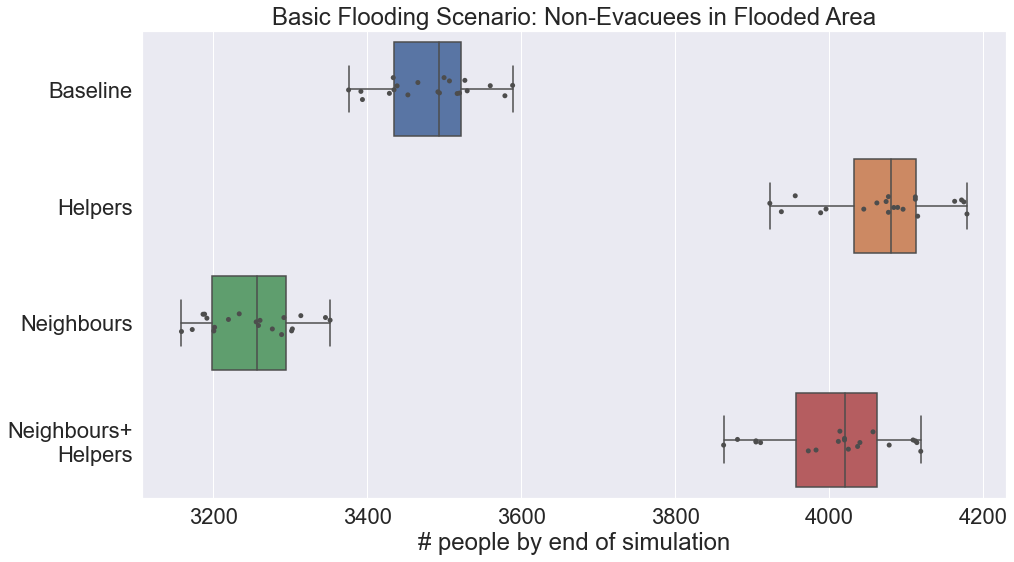

In [282]:
selectInZone = {'flooded': ['inZone']}
selectEvacs = {'status': ['Evacuated']}

#exportCountByScenario(holder, "numInZone_Typhoon16.eps", "Typhoon 16 Scenario: Non-Evacuees in Flooded Area", 
#                      "RitsurinDemo-TakamatsuTyphoon16.shp", selectInZone, selectNonEvacs )
exportCountByScenario(holder, 'ID', "numInZone_BasicFlooding.eps", "Basic Flooding Scenario: Non-Evacuees in Flooded Area", 
                      "RitsurinDemo-TakamatsuWaterFlooded.shp", selectInZone, excludeAtts = selectEvacs)


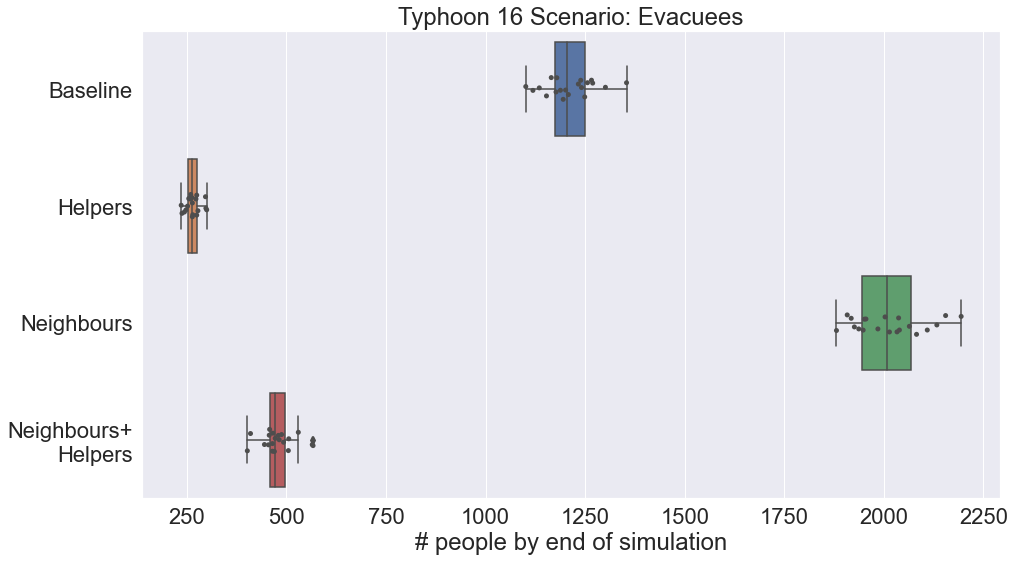

In [281]:
exportCountByScenario(holder, 'ID', figureFilename = "numInZone_Evacuated_Typhoon16.eps", figureTitle = "Typhoon 16 Scenario: Evacuees", 
    waterFile = "RitsurinDemo-TakamatsuTyphoon16.shp", includeAtts = selectEvacs)


Noticeable trends:
- The most effective evacuation approach is when neighbours bring others with them. This gets more people out of the target area than does independent choice.
- Baseline sees fewer people staying in the area, relative to the helpers options; helpers delay evacuation relative to individual assessment

This suggests that we're not just failing to identify people, and there's not an issue with how we're outputting things - it really is that more people are leaving the area in the cases of Neighbours (and the Baseline, relatively)

Now we ask ourselves - where exactly are these people who have stayed in the danger zone through the end of the simulation? Is it the case that they're concentrated somewhere? Isolated somehow? 

We can plot their final locations accordingly:

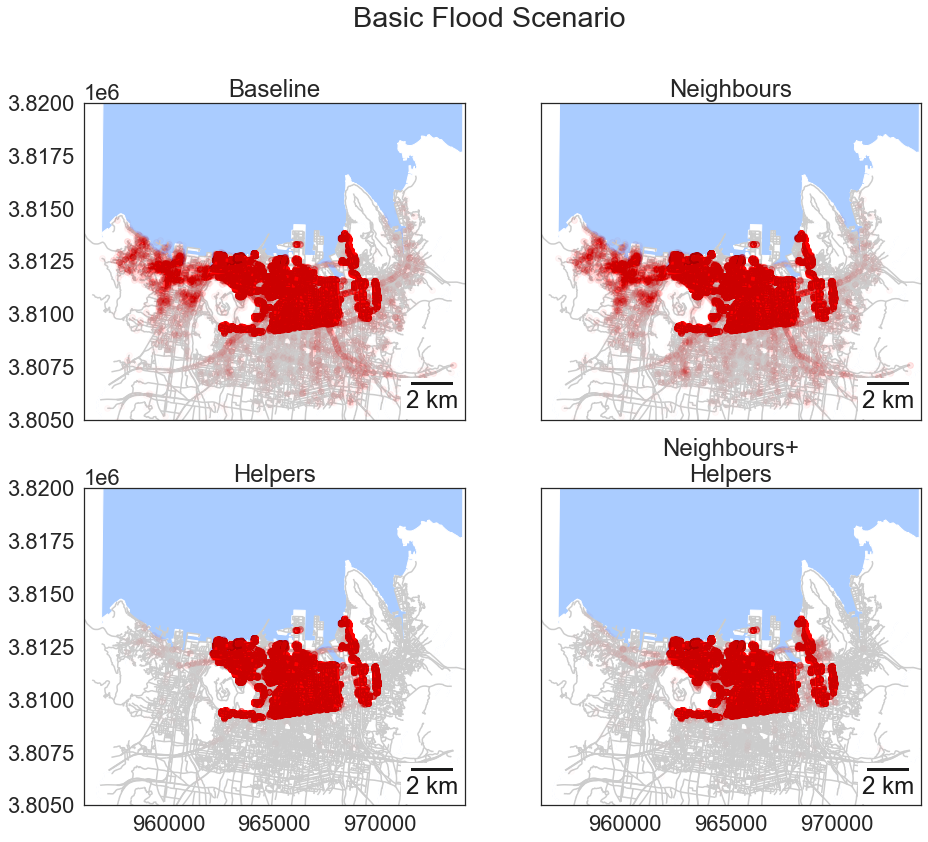

In [274]:

sns.set_style('white')

exportMapByScenario(holder, "locsInZone_flooded.png", "Basic Flood Scenario", waterFloodedFile, roadsFile,
                    waterFile = "RitsurinDemo-TakamatsuWaterFlooded.shp")

#exportMapByScenario(holder, "locsInZone_flooded.png", "Typhoon 16 Scenario", waterTyphoon16File, roadsFile,
#                    waterFile = "RitsurinDemo-TakamatsuTyphoon16.shp")

Let's look at evacuee locations specifically

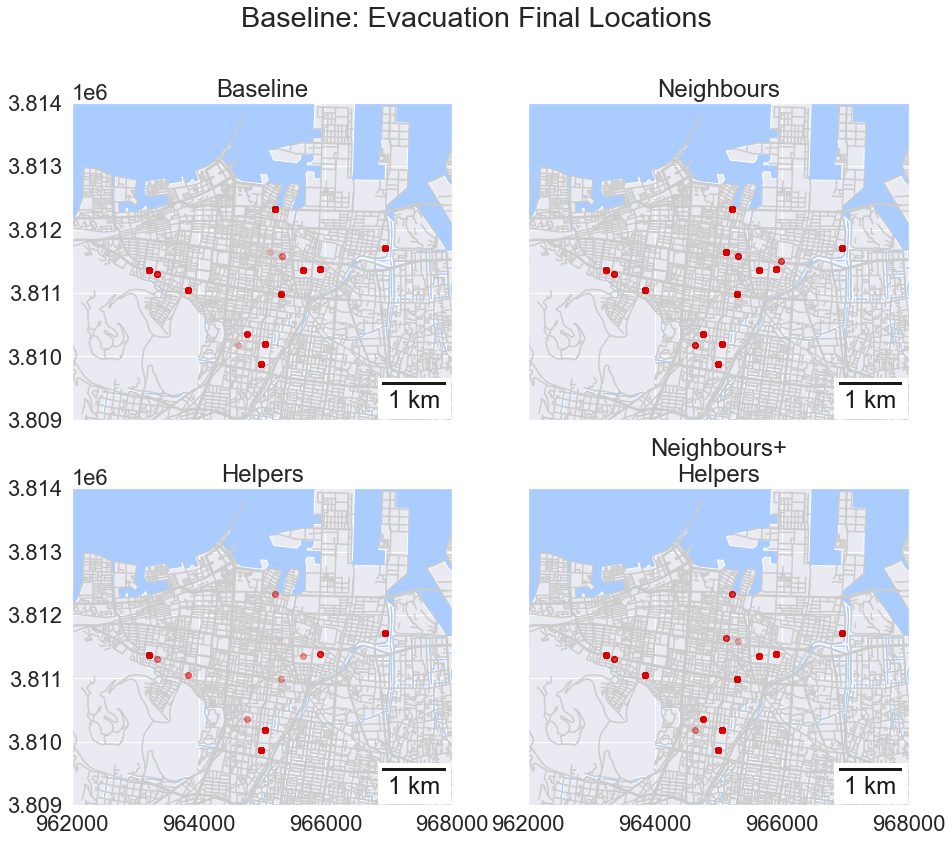

In [286]:
myEvacs = selectOnAttribute(holder, {'status': ['Evacuated']}, 
                            waterFile = "RitsurinDemo-TakamatsuWaterFlooded.shp")
exportMapByScenario(myEvacs, "evaclocs.png", "Baseline: Evacuation Final Locations", waterFloodedFile, roadsFile,
                    waterFile = "RitsurinDemo-TakamatsuWaterFlooded.shp",
                   xlim = [962000, 968000], ylim = [3809000, 3814000])


We can see the shelters clearly from the final locations of evacuees - and interestingly, there are different patterns of usage. The Neighbours context clearly shows heavy usage of every single shelter. The Baseline case shows similar rates, and the Neighbours + Helpers context has different weightings but still fairly similar usage (although only the Neighbours option sees extensive usage of the MatsushimaCom shelter).

Just to confirm, we're dealing with the same population of people in each of the contexts - right? They're coming from the same places?

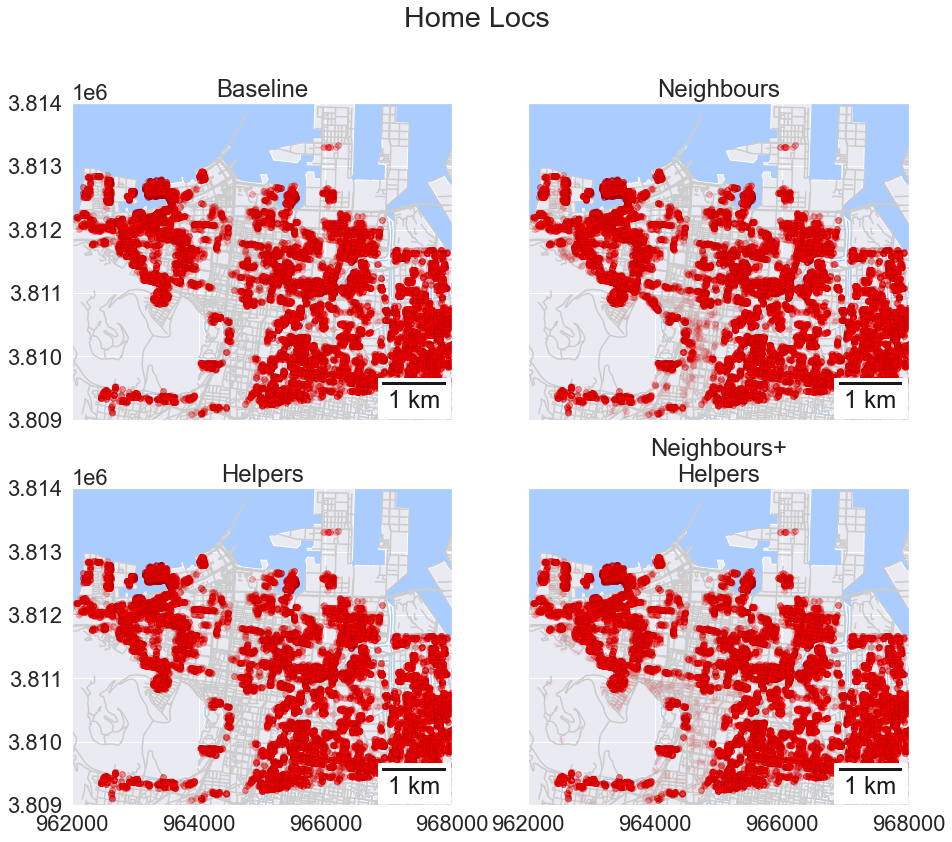

In [287]:
exportMapByScenario(holder, "homelocs.png", "Home Locs", waterFloodedFile, roadsFile,
                    waterFile = "RitsurinDemo-TakamatsuWaterFlooded.shp", xcolname='x_home', ycolname='y_home', 
                    xlim = [962000, 968000], ylim = [3809000, 3814000])


Interestingly, it seems as if a slightly different group of people get pulled into Neighbour-based evacuations - some of the centre of the city ends up getting involved in the simulation and evacuating when the non-Neighbour scenarios do not see so many evacuees.

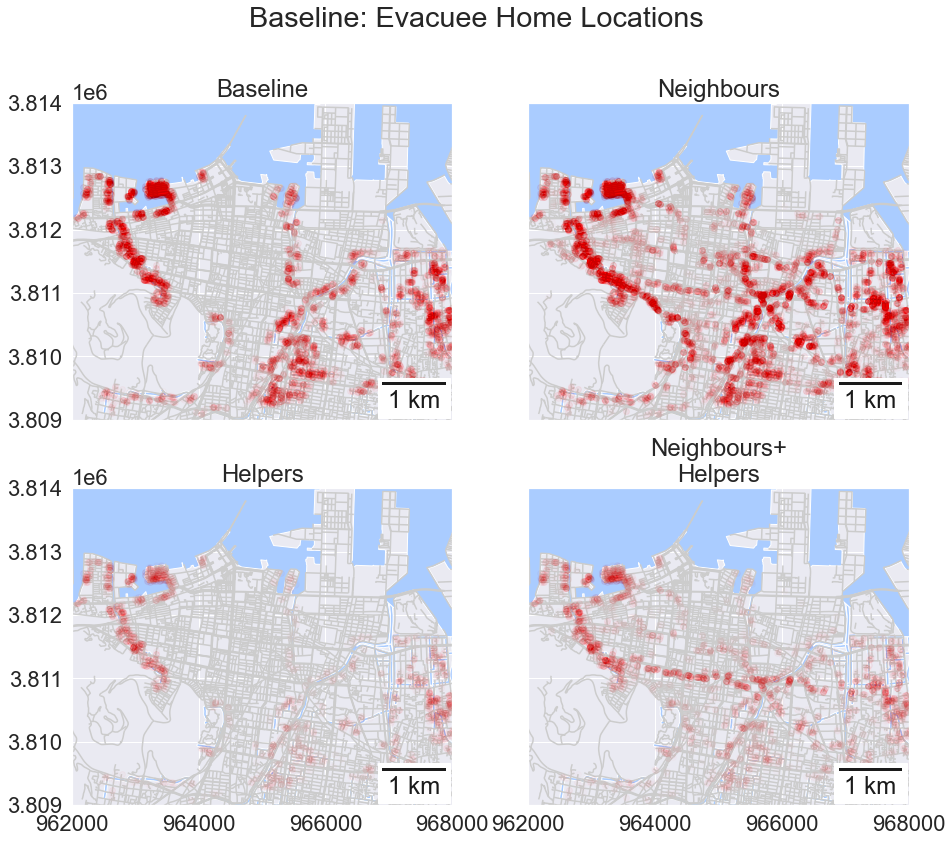

In [288]:
myEvacs = selectOnAttribute(holder, {'status': ['Evacuated']}, 
                            waterFile = "RitsurinDemo-TakamatsuWaterFlooded.shp")
exportMapByScenario(myEvacs, "evac_homeLocs.png", "Baseline: Evacuee Home Locations", waterFloodedFile, roadsFile,
                    waterFile = "RitsurinDemo-TakamatsuWaterFlooded.shp",
                   xlim = [962000, 968000], ylim = [3809000, 3814000], xcolname='x_home', ycolname='y_home')


### Visualising the census for comparison

Let's try something really wild - let's try reading in the census and seeing how that looks. What could go wrong.

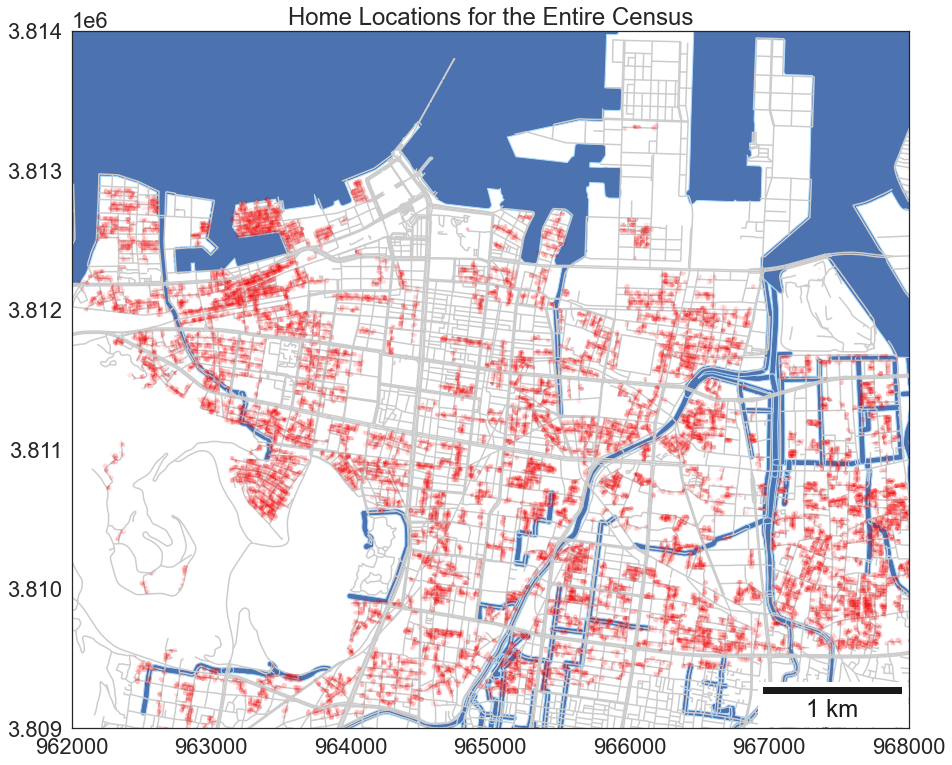

In [355]:
# input files for visualisation

censusFilename = "/Users/swise/Projects/hitomi/data/elderDemo/householdLocations.txt"

# read them in
roads = geopandas.read_file(roadsFilename)
buildings = geopandas.read_file(baseShapefileFilename)
water = geopandas.read_file(waterFloodedFile)

raw_census = pd.DataFrame(pd.read_csv(censusFilename, sep='\t', header=None))
raw_census.rename(columns={0: 'name', 1: 'building', 2: 'count'}, inplace=True)

# join the building and census data to get home locations for the entire population 
spaceCensus = buildings.join(raw_census.set_index('building'), on='fid', how='right')
#spaceCensus.head()

# now visualise everything

# set up the figure
#sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,15))

# plot everything
water.plot(ax=ax, edgecolor='#AADDFF', zorder=0)
roads.plot(ax=ax, edgecolor='#CCCCCC', zorder=1)
spaceCensus.plot(ax=ax, color='none', edgecolor='red', linewidth=3, alpha=.05, zorder=2)

# adjust how the map is rendered
ax.set_title("Home Locations for the Entire Census")
ax.set_xlim([962000, 968000])
ax.set_ylim([3809000, 3814000])
scalebar = ScaleBar(dx=1, location='lower right')
ax.add_artist(scalebar)

# save the figure out
plt.savefig('censusHomes.png', format='png', dpi=72)

### Comparing evacuation travel time

Let's look more closely at the evacuees in different scenarios

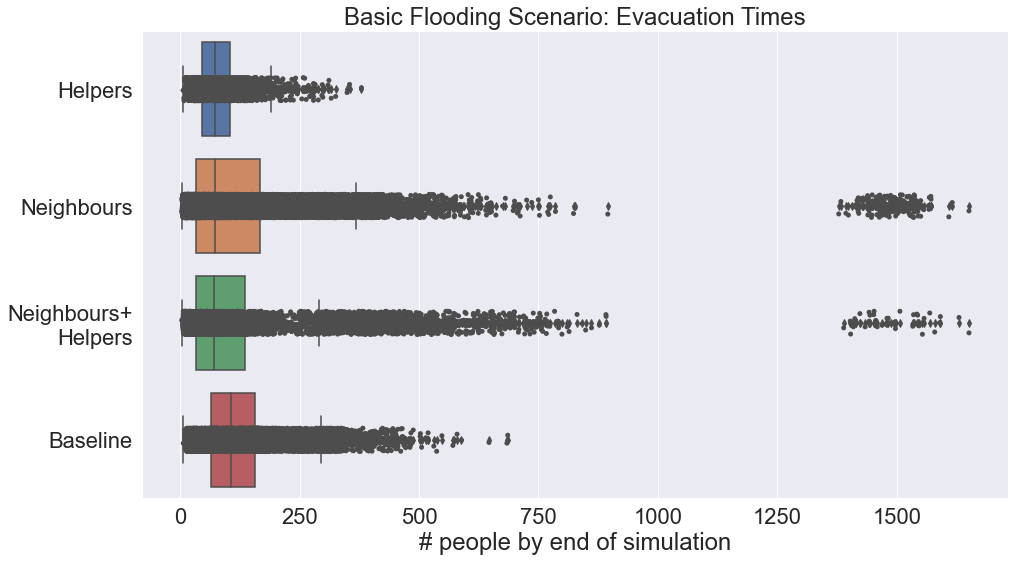

In [429]:
selectEvacs = {'status': ['Evacuated']}
exportCountByScenario(holder, 'evacuatingTime', "evacuatingTime_BasicFlooding.png", 
                      "Basic Flooding Scenario: Evacuation Times", 
                      "RitsurinDemo-TakamatsuWaterFlooded.shp", includeAtts=selectEvacs, aggregate=False)


Above, we can see that for the Neighbours-related instances, a minority of people spend a huge amount of time evacuating. Why is this? Let's explore the long evacuations a little more thoroughly.

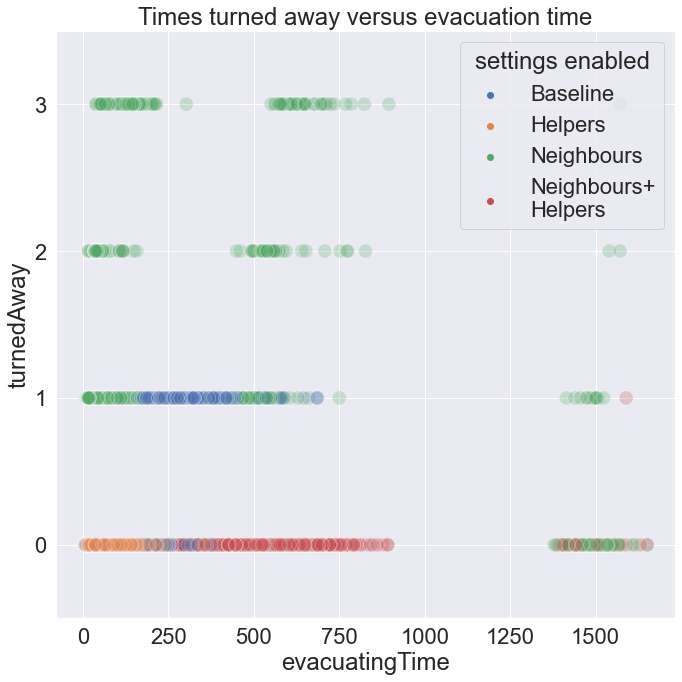

In [409]:
# select and process the data
myEvacs = selectOnAttribute(holder, {'status': ['Evacuated']}, 
                            waterFile = "RitsurinDemo-TakamatsuWaterFlooded.shp")
#longEvacs = myEvacs[myEvacs["evacuatingTime"] > 1000]

# set up the figure
fig, ax = plt.subplots(figsize=(10,10))
hueOrder = ['Baseline', 'Helpers', 'Neighbours', 'Neighbours+\nHelpers']

# plot the data
sns.scatterplot(data=myEvacs, x="evacuatingTime", y="turnedAway", hue="settings enabled", hue_order = hueOrder,
                s=200, alpha=.25)

#adjust the chart's portrayal
#ax.set_xlim([-.75,5.75])
ax.set_title("Times turned away versus evacuation time")
ax.set_yticks(range(0, 4, 1))
ax.set_ylim([-.5, 3.5])
plt.tight_layout()

# save the figure out
plt.savefig('timesTurnedAwayVsEvacuationTime.png', format='png', dpi=72)

In [414]:
dummy = holder[holder["x_loc"] == holder["x_home"]]
dummy = dummy[dummy["y_loc"] == dummy["y_home"]]
pd.unique(dummy["status"])

dummy = dummy[dummy["status"] != 'Home']
dummy

ID  age             status  evacuatingTime  \
172   3216689506977128894   12          Preparing          1363.0   
3360  2223369200385338027    3          Preparing          1387.0   
851   -329853787490943004   16          Preparing          1454.0   
4129  3267478552967362931    1          Preparing          1396.0   
1038  8219531121454188260    8          Preparing          1405.0   
2187  7877730084552509635    5          Preparing          1468.0   
1143 -7979150292094229104    2          Preparing          1544.0   
1483  1976246066892050967   13          Preparing          1386.0   
1481 -8239357188216303452    0          Preparing          1548.0   
2410 -5511053156035380972    3          Preparing          1487.0   
2803  7010440246508460908    1          Preparing          1372.0   
2807  2441494876886082144    2          Preparing          1570.0   
1408 -1889654084054838696   13          Preparing          1451.0   
3020  7885396390986015423    9          Preparing          1401.0   
5390 -1304227985282204676    4          Preparing          1512.0   
8036 -6187319783611093088    9          Preparing          1523.0   
3042  2959891840210560979    0          Preparing          1541.0   
5323  7010440246508460908    1          Preparing          1372.0   
330   3216689506977128894   12          Preparing          1363.0   
1082 -5120078319618170133   14          Preparing          1440.0   
3273    78782543625400147    3          Preparing          1498.0   
6346  2223369200385338027    3          Preparing          1387.0   
1309  4975570706573895035    3          Preparing          1444.0   
4072 -2272507823501239374    0          Preparing          1482.0   
7630  3267478552967362931    1          Preparing          1396.0   
5452 -4791100663744834942   11          Preparing          1453.0   
877  -6556124292177827559   10          Preparing          1440.0   
1958 -7443227945907364263   11          Preparing          1464.0   
4561  6477016476663180553    1          Preparing          1466.0   
4939 -1730045940013940702    1          Preparing          1444.0   
4973  7609608699768495433    1          Preparing          1378.0   
4315  6895217146084576139    1          Preparing          1450.0   
933  -1056917285581145389    1          Preparing          1496.0   
3663  8999298715494775652    5          Preparing          1461.0   
488  -5161762526533804219    0          Preparing          1523.0   
510   3836043008518407544    4  TravelToDependent          1423.0   
4069 -8109907743219676168    8          Preparing          1401.0   
1058   269160482700867819   11          Preparing          1392.0   
2259 -7490256307349351588    9          Preparing          1396.0   
2774  1991875649514239953    2          Preparing          1526.0   
1488 -7447275133121166232   13          Preparing          1517.0   
5597  1352180813749163153    7          Preparing          1426.0   
6457  8939627519569008202    8          Preparing          1405.0   
6613 -4588675361525275161   16          Preparing          1415.0   
6946  2673626713831289898    8          Preparing          1430.0   
8254  6895217146084576139    1          Preparing          1500.0   
4476 -2073122215579644009    0          Preparing          1425.0   
956   3836043008518407544    4  TravelToDependent          1423.0   
4061  5538480700814179753    6          Preparing          1421.0   
7579 -8109907743219676168    8          Preparing          1401.0   
3040  6644944410234076715    9          Preparing          1405.0   
7804 -2279111891413095091    0          Preparing          1522.0   
1760 -6662349397388203491    8          Preparing          1521.0   
2550  7609608699768495433    1          Preparing          1378.0   
459  -1056917285581145389    1          Preparing          1519.0   
2068 -6976744474180331704   13          Preparing          1489.0   
2007   269160482700867819   11          Preparing          1392.0   

           flooded  

### Outliers - what's their deal?

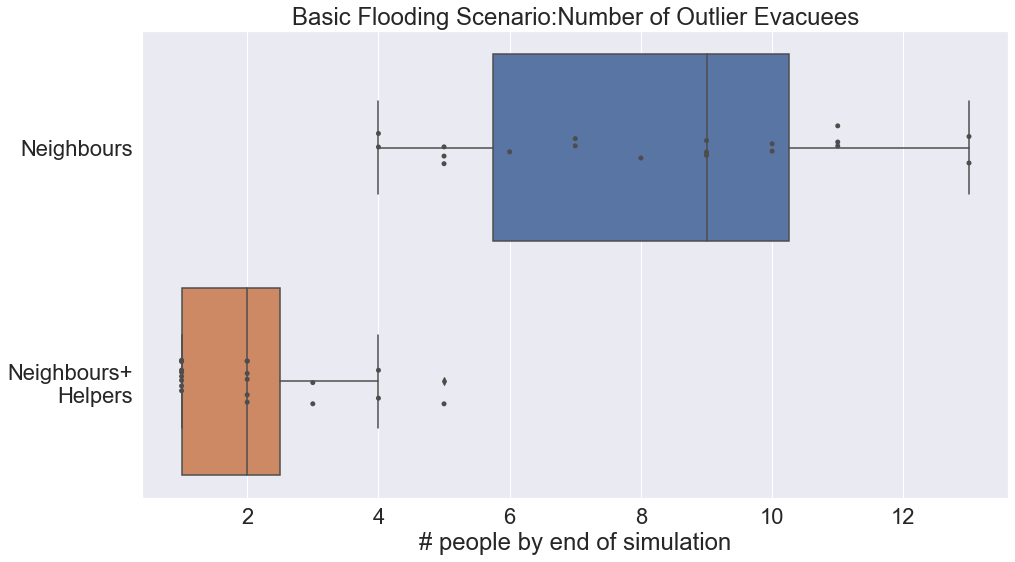

In [424]:
outliers = holder[holder["evacuatingTime"] >= 1000]

selectEvacs = {'status': ['Evacuated']}

exportCountByScenario(outliers, 'ID', figureFilename = "numOutliers_BasicFlooding.eps", 
                      figureTitle = "Basic Flooding Scenario:Number of Outlier Evacuees", 
                     waterFile = "RitsurinDemo-TakamatsuWaterFlooded.shp", includeAtts = selectEvacs)


And where do they live?

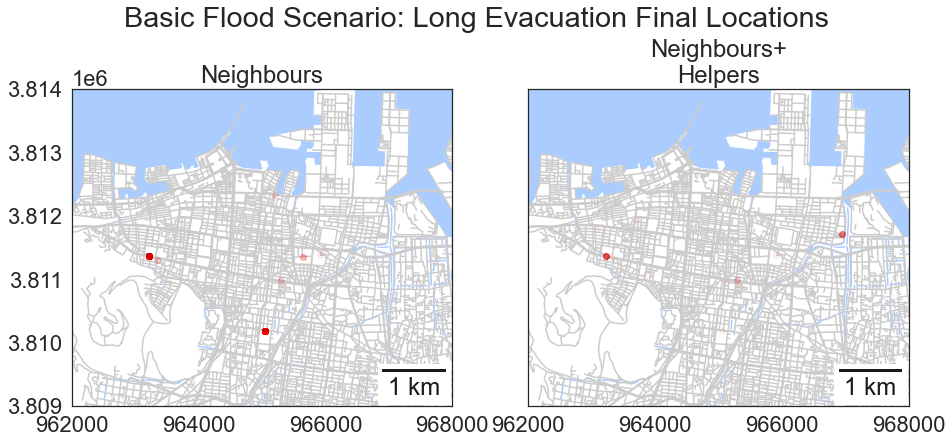

In [427]:
sns.set_style('white')

exportMapByScenario(outliers, "longEvacFinalLocs.png", "Basic Flood Scenario: Long Evacuation Final Locations", 
                    waterFloodedFile, roadsFile, 
                    xlim = [962000, 968000], ylim = [3809000, 3814000]
                       )


#exportMapForLocationInZone(holder, "RitsurinDemo-TakamatsuTyphoon16.shp", waterTyphoon16File, roadsFile,
#                        "locsInZone_typhoon16.png", "Typhoon 16 Scenario")

### Comparing the number of people in shelters

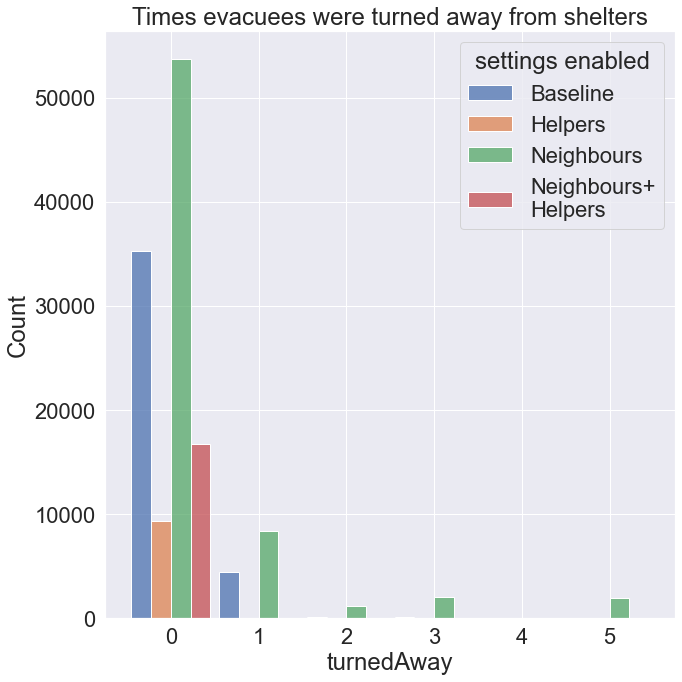

In [400]:
# pull out the relevant data
evacs = holder[holder['status'] == 'Evacuated']

# set up the figure
fig, ax = plt.subplots(figsize=(10,10))
hueOrder = ['Baseline', 'Helpers', 'Neighbours', 'Neighbours+\nHelpers']

# plot the data
sns.histplot(data=evacs, x="turnedAway", hue="settings enabled", 
             discrete=True, hue_order = hueOrder, shrink=.9,
             element='bars', multiple="dodge")

#adjust the chart's portrayal
ax.set_xlim([-.75,5.75])
ax.set_title("Times evacuees were turned away from shelters")
plt.tight_layout()

# save the figure out
plt.savefig('timesTurnedAway.png', format='png', dpi=72)

### Other spatial assessments

In [ ]:
# pull out the runs on a specific water setting
defaultFlooding = holder[holder["waterShapefile"] == "RitsurinDemo-TakamatsuWaterFlooded.shp"]

settingNames = defaultFlooding.apply(
    lambda x: ("Neighbours " if x['neighboursEnabled'] else "") + 
    ("Helpers" if x['helpersEnabled'] else ""), axis=1)

defaultFlooding["settings enabled"] = settingNames
defaultFlooding["final status"] = defaultFlooding.index

statusOrder = pd.unique(defaultFlooding['status'])
settingsOrder = pd.unique(settingNames)


#sns.boxplot(data=defaultFlooding, x='status', y='ID', hue='settings enabled')
#define grid
g = sns.FacetGrid(data=defaultFlooding, col='status', col_wrap=3, aspect=1,
                  despine=True, col_order=statusOrder, sharey=False, margin_titles=False)

#add plots to grid
g.map(sns.boxplot, 'settings enabled', 'ID', order=settingsOrder)

g.set_axis_labels("Parameter Settings", "Number of People")
g.set_titles(col_template="{col_name} Status", row_template="{row_name}")

g.figure.subplots_adjust(wspace=3, hspace=3)

In [ ]:
# pull out the runs on a specific water setting
defaultFlooding = holder[holder["waterShapefile"] == "RitsurinDemo-TakamatsuWaterFlooded.shp"]

settingNames = defaultFlooding.apply(
    lambda x: ("Neighbours " if x['neighboursEnabled'] else "") + 
    ("Helpers" if x['helpersEnabled'] else ""), axis=1)
settingNames = settingNames.apply(lambda x: "Default" if len(x) == 0 else x)

defaultFlooding["settings enabled"] = settingNames
defaultFlooding["final status"] = defaultFlooding.index

statusOrder = pd.unique(defaultFlooding['status'])
settingsOrder = pd.unique(settingNames)


sns.set_theme(style="darkgrid")

# Initialize the figure
f, ax = plt.subplots(figsize=(10,10))
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="ID", y="status", hue="settings enabled", hue_order=settingsOrder,
              data=defaultFlooding, dodge=True, alpha=.45, zorder=1, size=10)

ax.legend(title="Parameters Enabled",
          loc="lower right", frameon=True)

### Archive - old read in files

In [ ]:
def extractThoseInZone(df, waterFile):
    
    # pull out the runs on a specific water setting
    defaultFlooding = df[df["waterShapefile"] == waterFile]

    # pull out only the people who were in the zone at the end of the time
    defaultFlooding = defaultFlooding[defaultFlooding['flooded'] == "inZone"]

    # exclude the people who have successfully evacuated (to shelters which are still within the zone)
    defaultFlooding = defaultFlooding[defaultFlooding['status'] != "Evacuated"]

    return defaultFlooding


### Archive - experimenting with EMA Workbench

In [ ]:
from ema_workbench import (Model, RealParameter, CategoricalParameter, ScalarOutcome, ArrayOutcome, ema_logging,
                           perform_experiments)
import subprocess
import pandas as pd
import math
import numpy as np
import os

import matplotlib.pyplot as plt

In [ ]:
def processMe(outputFilename, newOutputFilename, seed):
    
    results = pd.read_csv(outputFilename, sep="\t")
    
    r_evacs = results[results["evacuating"] > 0]
    countEvacuating = r_evacs.shape[0]
    if pd.isna(countEvacuating):
        countEvacuating = 0
    
    completes = r_evacs[r_evacs["completed"]=="Evacuated"]
    successful = completes.shape[0]
    if pd.isna(successful):
        successful = 0
        
    r_flooding = results[results["flooded"]=="inWater"]
    flooded = r_flooding.shape[0]
    if pd.isna(flooded):
        flooded = 0
    
    os.system('mv '+outputFilename+ ' ' + newOutputFilename)
    
    return {'trueseed': float(seed),
            'countEvacuating': float(countEvacuating), 
            'successfulEvacuations': float(successful),
            'flooded': float(flooded)}#,
#           'evacuatingTimes': [results['evacuatingTime']]}

def takamatsu_model(rawseed, agesEnabled ='true', neighbours = 'true', designated = 'true', flooding = 'RitsurinDemo/TakamatsuWaterFlooded.shp'):
    
    outputDir="/Users/swise/workspace/takamatsu/python/"
    
    seed = str(int(rawseed))
    subprocess.call(['java', '-Xms6G', '-jar', 'takamatsuABM.jar', seed, agesEnabled, outputDir, flooding, neighbours, designated])
    outputFilename = outputDir + seed + "_recordNoPlan.txt"
    newFloodName = flooding.split('/')[-1]
    newFloodName = newFloodName.split('.')[0]
    newOutputFilename = "output_bkup_" + seed + "_" + neighbours + "_" + designated + "_" + newFloodName + ".txt"
    #https://stackoverflow.com/questions/50938879/copy-file-rename-it-iterate-and-repeat
    #return { 'trueseed': 1., 'countEvacuating': 1., 'successfulEvacuations': 1., 'flooded': 1., 'evacuatingTimes': [1., 2.]}
    return processMe(outputFilename, newOutputFilename, seed)


In [ ]:
#takamatsu_model('123', 'true')
#subprocess.call(['java', '-jar', 'takamatsuABM.jar', seed, 'true', outputDir])

In [ ]:
### ema_logging.LOG_FORMAT = '[%(name)s/%(levelname)s/%(processName)s] %(message)s'
ema_logging.log_to_stderr(ema_logging.INFO)

model = Model('takamatsuSim', function=takamatsu_model)  # instantiate the model

# specify uncertainties
model.uncertainties = [RealParameter('rawseed', 1, 10000),
                      CategoricalParameter('agesEnabled', ['true', 'false']),
                      CategoricalParameter('flooding', ['RitsurinDemo/TakamatsuWaterFlooded.shp', 'RitsurinDemo/TakamatsuTyphoon16.shp']),
                      CategoricalParameter('neighbours', ['true', 'false']),
                      CategoricalParameter('designated', ['true', 'false'])]

# specify outcomes
model.outcomes = [ScalarOutcome('trueseed'),
                 ScalarOutcome('countEvacuating'),
                 ScalarOutcome('successfulEvacuations'),
                 ScalarOutcome('flooded')]#,
#                 ArrayOutcome('evacuatingTimes')]

#results = perform_experiments(model, 100)

In [ ]:
results

In [ ]:
def some_model(x1=None, x2=None, x3=None):
    return {'y':x1*x2+x3}


In [ ]:
### ema_logging.LOG_FORMAT = '[%(name)s/%(levelname)s/%(processName)s] %(message)s'
ema_logging.log_to_stderr(ema_logging.INFO)

model = Model('takamatsuSim', function=some_model)#takamatsu_model)  # instantiate the model

model.uncertainties = [RealParameter("x1", 1, 10),
                       RealParameter("x2", 1, 10),
                       RealParameter("x3", 1, 10)]
#specify outcomes
model.outcomes = [ScalarOutcome('y')]

results = perform_experiments(model, 10)

In [ ]:
results

In [ ]:
plt.hist(results[1]['countEvacuating'])

In [ ]:
ageOn = results[0]['agesEnabled']
times = results[1]['evacuatingTimes']

ageTimes = times[ageOn == 'true']
nonAgeTimes = times[ageOn == 'false']

In [ ]:
mystuff = []
for a in ageTimes:
    raw = a[a > 0]
    mystuff.append(np.mean(raw))
plt.hist(mystuff)

In [ ]:
top = 20
weight = 40
bins = []
for i in range(10):
    bins.append(i * weight)
bins.append(top * weight)

In [ ]:
for r in results[1]['evacuatingTimes']:
    cleaned = r[r > 0]
    plt.hist(cleaned, alpha=.3, bins=bins)

In [ ]:
plt.scatter(results[0]['x1'], results[1]['y'])

In [ ]:
from ema_workbench.analysis.plotting import lines

figure = lines(results, density=True) #show lines, and end state density
plt.show() #show figure
